# Imports

In [1]:
from pipeline import loading_pipeline
from model_training import PyTorchModel
from model_training import evaluate_classification_model
import torch
import torch.nn as nn
import numpy as np

In [2]:
X_train, y_train, X_test, y_test = loading_pipeline(downsample=256)

Number of samples: 8600
Signal Length: 2816
X-Shape: (8100, 1408, 2)
y-Shape: (8100,)
X-Shape: (500, 1408, 2)
y-Shape: (500,)
Augmented X.shape: (40500, 1152, 2)
Augmented y.shape: (40500,)
Trimmed X.shape: (500, 1152, 2)


In [3]:
unique, counts = np.unique(y_train, return_counts=True)
class_balance = dict(zip(unique, counts))

print("Class Balance:")
for class_label, count in class_balance.items():
    print(f"Class {class_label}: {count} samples")

Class Balance:
Class 0: 8100 samples
Class 1: 8100 samples
Class 2: 8100 samples
Class 3: 8100 samples
Class 4: 8100 samples


# LSTM

In [8]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # x2 for bidirectional

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # x2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Using the last time step only
        return out

In [9]:
# Initialize the LSTM model
input_size = X_train.shape[2]  # Number of features per time step
num_classes = len(np.unique(y_train))  # Number of unique classes
hidden_size = 64  # Can be adjusted
num_layers = 2  # Can be adjusted

lstm_model = LSTMClassifier(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, num_classes=num_classes, dropout_rate=0.5)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PyTorchModel Wrapper
model = PyTorchModel(lstm_model, criterion, optimizer, device)

Epoch [1/25], Train Loss: 1.6089, Val Loss: 1.6075
Epoch [2/25], Train Loss: 1.6085, Val Loss: 1.6069
Epoch [3/25], Train Loss: 1.6085, Val Loss: 1.6065
Epoch [4/25], Train Loss: 1.6084, Val Loss: 1.6075
Epoch [5/25], Train Loss: 1.6083, Val Loss: 1.6073
Epoch [6/25], Train Loss: 1.6082, Val Loss: 1.6072
Epoch [7/25], Train Loss: 1.6081, Val Loss: 1.6064
Epoch [8/25], Train Loss: 1.6082, Val Loss: 1.6078
Epoch [9/25], Train Loss: 1.6082, Val Loss: 1.6067
Epoch [10/25], Train Loss: 1.6081, Val Loss: 1.6068
Epoch [11/25], Train Loss: 1.6081, Val Loss: 1.6063
Epoch [12/25], Train Loss: 1.6081, Val Loss: 1.6065
Epoch [13/25], Train Loss: 1.6080, Val Loss: 1.6068
Epoch [14/25], Train Loss: 1.6079, Val Loss: 1.6067
Epoch [15/25], Train Loss: 1.6078, Val Loss: 1.6065
Epoch [16/25], Train Loss: 1.6077, Val Loss: 1.6058
Epoch [17/25], Train Loss: 1.6075, Val Loss: 1.6066
Epoch [18/25], Train Loss: 1.6076, Val Loss: 1.6060
Epoch [19/25], Train Loss: 1.6075, Val Loss: 1.6067
Epoch [20/25], Train 

/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


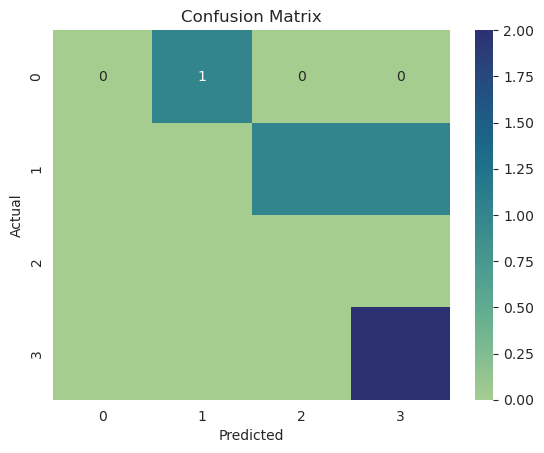


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.67      1.00      0.80         2

    accuracy                           0.40         5
   macro avg       0.17      0.25      0.20         5
weighted avg       0.27      0.40      0.32         5


/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

In [10]:
evaluate_classification_model(model, X_train, y_train, X_test, y_test)